# EFF positions - baseline 01 vs baseline 02

This notebook compares time-stamps and positions of the Swarm EEFxTMS_2F product.

In [1]:
from numpy import asarray
from spacepy.pycdf import CDF, const

CDF_EPOCH_TYPE = const.CDF_EPOCH.value
CDF_EPOCH_1970 = 62167219200000.0

EEF_01_FILENAME = "SW_OPER_EEFATMS_2F_20160101T002548_20160101T221515_0103.DBL"
EEF_02_FILENAME = "SW_OPER_EEFATMS_2F_20160101T000000_20160101T235959_0202.cdf"


def load_data(filename):
    
    def cdf_epoch_to_datetime64(cdf_epoch):
        return asarray(
            (cdf_epoch - CDF_EPOCH_1970)*1e3
        ).astype('datetime64[us]')


    def get_variable(cdf, variable):
        raw_var = cdf.raw_var(variable)
        data = raw_var[...]
        if raw_var.type() == CDF_EPOCH_TYPE:
            return cdf_epoch_to_datetime64(data)
        return data
    
    with CDF(filename) as cdf:
        return {key: get_variable(cdf, key) for key in cdf}

# load data from baseline 01 and 02 sample EEF products
data_eef01 = load_data(EEF_01_FILENAME)
data_eef02 = load_data(EEF_02_FILENAME)

In [2]:
from numpy import nan
from viresclient import SwarmRequest

# load spacecraft trajectory from MAGx_LR product

SPACECRAFT = 'A'
START_TIME='2016-01-01T00:00:00Z'
END_TIME='2016-01-02T00:00:00Z'


def extract_variables(xarray_data, variables):
    return {
        variable: xarray_data[variable].values
        for variable in variables 
    }


try:
    request = SwarmRequest()

    request.set_collection('SW_OPER_MAG%s_LR_1B' % SPACECRAFT)
    request.set_products(
        measurements=[],
        auxiliaries=['OrbitDirection'],
    )
    response = request.get_between(
        start_time=START_TIME,
        end_time=END_TIME,
    )
    print('Sources:\n\t%s' % '\n\t'.join(response.sources))
    #boundaries = response.as_xarray()

except Exception as error:
    print('ERROR: ', error)
else:
    data_maglr = extract_variables(
        response.as_xarray(),
        ['Timestamp', 'Latitude', 'Longitude', 'OrbitDirection']
    )
    response = None

    data_maglr['Latitude'][data_maglr['OrbitDirection'] < 0] = nan

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (2.942MB)


Sources:
	SW_OPER_MAGA_LR_1B_20151231T000000_20151231T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20160101T000000_20160101T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20160102T000000_20160102T235959_0505_MDR_MAG_LR


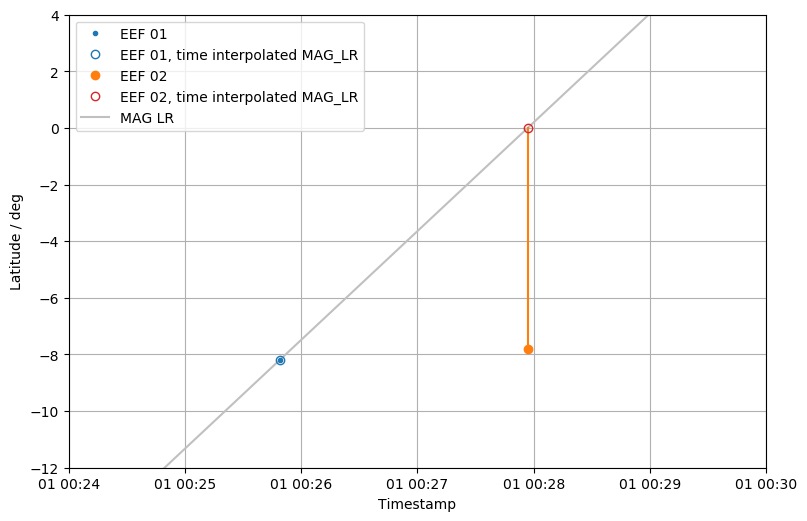

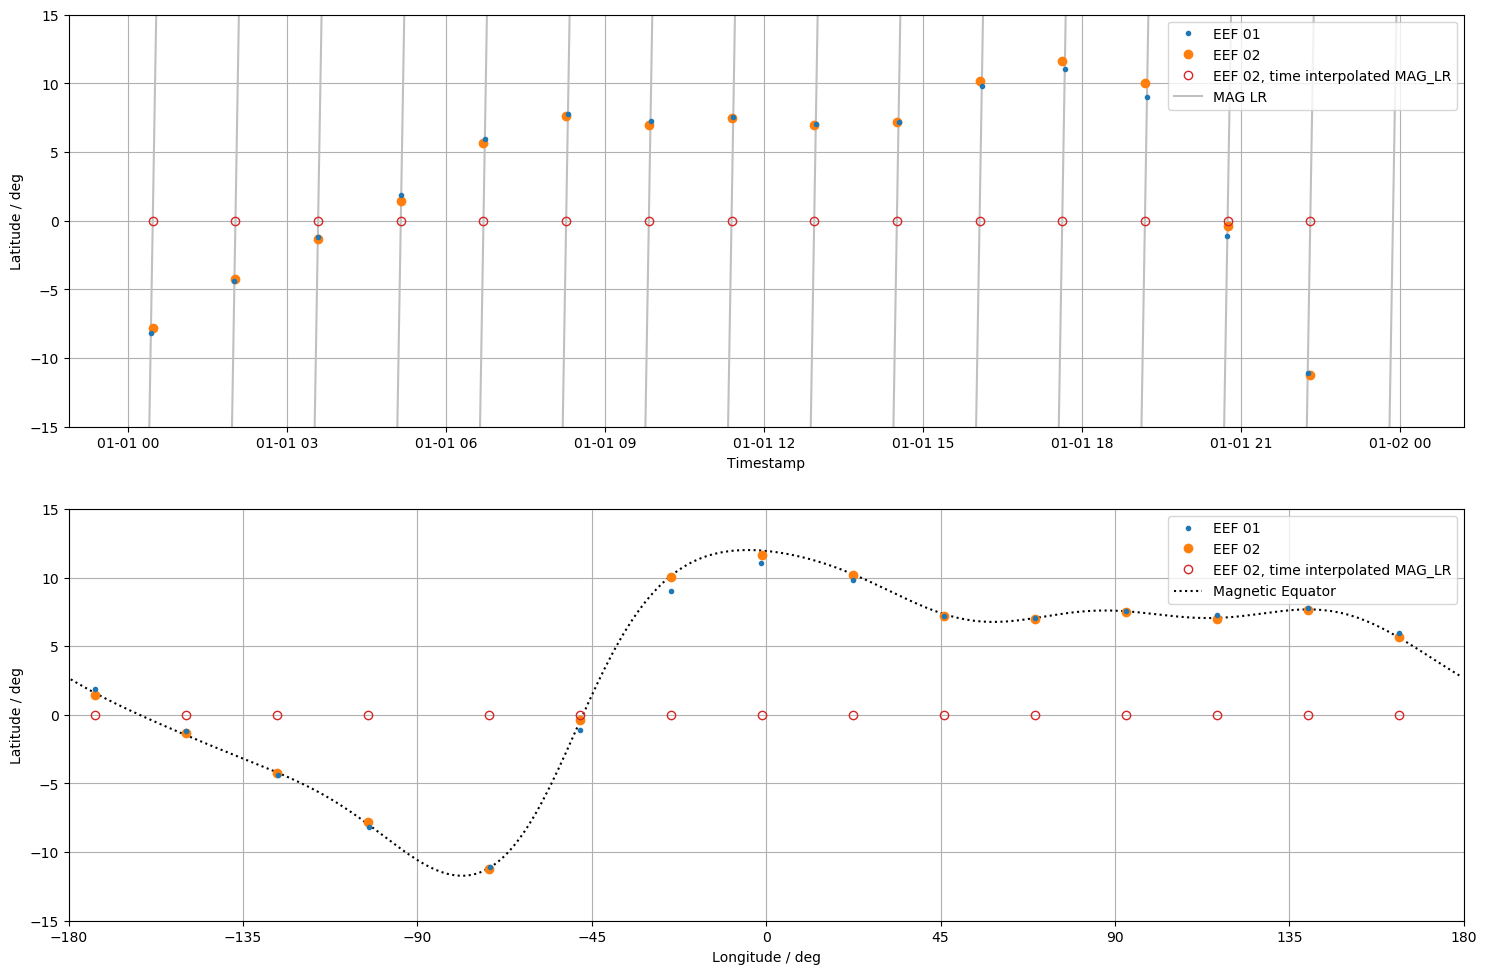

In [4]:
from numpy import arange, zeros, full, concatenate
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure, subplot, show
from apexpy import Apex

%matplotlib inline

# magnetic equator
qd_lon = arange(-180, 180)
qd_lat = zeros(qd_lon.shape)
height = full(qd_lon.shape, 110)
meq_lat, meq_lon = Apex(2016).convert(qd_lat, qd_lon, 'qd', 'geo', height=height)
idx = (abs(meq_lon[1:] - meq_lon[:-1]) > 180).nonzero()[0][0] + 1
meq_lat = concatenate((meq_lat[idx:], meq_lat[:idx]))
meq_lon = concatenate((meq_lon[idx:], meq_lon[:idx]))

# interpolated MAGx_LR lolcations
time_to_mag_latitude = interp1d(
    data_maglr['Timestamp'].astype('datetime64[us]').astype('int64'),
    data_maglr['Latitude'],
    kind='linear'
)
data_eef01['Latitude_MAG'] = time_to_mag_latitude(data_eef01['timestamp'].astype('int64'))
data_eef02['Latitude_MAG'] = time_to_mag_latitude(data_eef02['Timestamp'].astype('int64'))

time_to_mag_longitude = interp1d(
    data_maglr['Timestamp'].astype('datetime64[us]').astype('int64'),
    data_maglr['Longitude'],
    kind='linear'
)
data_eef01['Longitude_MAG'] = time_to_mag_longitude(data_eef01['timestamp'].astype('int64'))
data_eef02['Longitude_MAG'] = time_to_mag_longitude(data_eef02['Timestamp'].astype('int64'))



fig = figure(figsize=(9, 6), dpi=100)

ax = subplot(1, 1, 1)
f_maglr, = ax.plot(data_maglr['Timestamp'], data_maglr['Latitude'], '-', c='silver')
for time, lat, lat_mag in zip(data_eef02['Timestamp'], data_eef02['Latitude'], data_eef02['Latitude_MAG']):
    ax.plot([time, time], [lat, lat_mag], '-', c='tab:orange')
f_eef02, = ax.plot(data_eef02['Timestamp'], data_eef02['Latitude'], 'o', c='tab:orange')
f_eef02_mag, = ax.plot(data_eef02['Timestamp'], data_eef02['Latitude_MAG'], 'o', c='tab:red', mfc='none')
f_eef01, = ax.plot(data_eef01['timestamp'], data_eef01['latitude'], '.', c='tab:blue')
f_eef01_mag, = ax.plot(data_eef01['timestamp'], data_eef01['Latitude_MAG'], 'o', c='tab:blue', mfc='none')
ax.set_xlim('2016-01-01T00:24', '2016-01-01T00:30')
ax.set_ylim(-12, +4)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Latitude / deg')
ax.grid()
ax.legend(
    (f_eef01, f_eef01_mag, f_eef02, f_eef02_mag, f_maglr),
    ('EEF 01', 'EEF 01, time interpolated MAG_LR', 'EEF 02', 'EEF 02, time interpolated MAG_LR', 'MAG LR')
)


fig = figure(figsize=(18, 12), dpi=100)

ax = subplot(2, 1, 1)
f_maglr, = ax.plot(data_maglr['Timestamp'], data_maglr['Latitude'], '-', c='silver')
f_eef02, = ax.plot(data_eef02['Timestamp'], data_eef02['Latitude'], 'o', c='tab:orange')
f_eef02_mag, = ax.plot(data_eef02['Timestamp'], data_eef02['Latitude_MAG'], 'o', c='tab:red', mfc='none')
f_eef01, = ax.plot(data_eef01['timestamp'], data_eef01['latitude'], '.', c='tab:blue')
ax.set_ylim(-15, +15)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Latitude / deg')
ax.grid()
ax.legend(
    (f_eef01, f_eef02, f_eef02_mag, f_maglr),
    ('EEF 01', 'EEF 02', 'EEF 02, time interpolated MAG_LR', 'MAG LR')
)

ax = subplot(2, 1, 2)
f_meq, = ax.plot(meq_lon, meq_lat, ':', c='black')
f_eef02, = ax.plot(data_eef02['Longitude'], data_eef02['Latitude'], 'o', c='tab:orange')
f_eef02_mag, = ax.plot(data_eef02['Longitude'], data_eef02['Latitude_MAG'], 'o', c='tab:red', mfc='none')
f_eef01, = ax.plot(data_eef01['longitude'], data_eef01['latitude'], '.', c='tab:blue')
ax.set_xlim(-180, +180)
ax.set_ylim(-15, +15)
ax.set_xticks([-180, -135, -90, -45, 0, +45, +90, +135, +180])
ax.set_xlabel('Longitude / deg')
ax.set_ylabel('Latitude / deg')
ax.grid()
ax.legend((f_eef01, f_eef02, f_eef02_mag, f_meq), ('EEF 01', 'EEF 02', 'EEF 02, time interpolated MAG_LR', 'Magnetic Equator'))

show()